# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using a pre-trained model's architecture and parameters to save time and cloud resources.

In [1]:
!ls pnp_dataset.zip || (aws s3 cp s3://danylo-ucla/pnp_dataset.zip ./)

pnp_dataset.zip


In [2]:
import matplotlib.pyplot as plt

In [3]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

E0000 00:00:1762710431.466137   14920 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762710431.471860   14920 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
from collegium.m02_cnn.utils.pnp_dataset import build_dataset

# See Tensorflow Dataset API for details
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_ds = build_dataset('train', include_labels=True)
score_ds = build_dataset('score', include_labels=False)
train_ds, score_ds

I0000 00:00:1762710434.340322   14920 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


(<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <_FlatMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

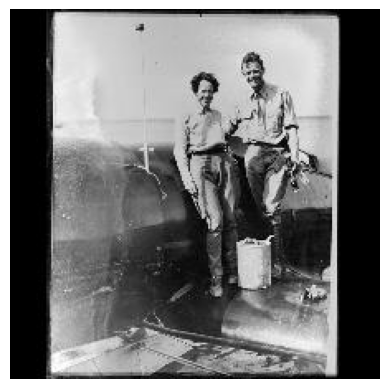

In [5]:
import keras

train_sample_x, train_sample_y = next(iter(train_ds))
plt.imshow(keras.ops.cast(train_sample_x, int))
plt.axis('off')
train_sample_y

<tf.Tensor: shape=(), dtype=int32, numpy=0>

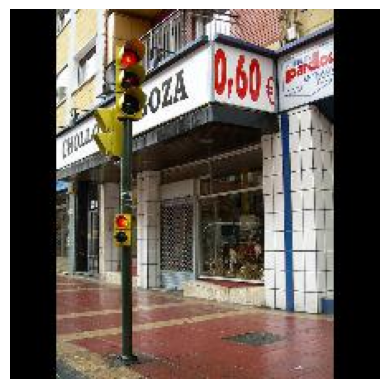

In [6]:
train_sample_x, train_sample_y = next(iter(train_ds.skip(1)))
plt.imshow(keras.ops.cast(train_sample_x, int))
plt.axis('off')
train_sample_y

In [ ]:
import keras_hub

# See https://keras.io/keras_hub/presets/ for more options of pre-trained backbones.
backbone = keras_hub.models.Backbone.from_preset(
    "mobilenet_v3_small_050_imagenet",
    # "mobilenet_v3_small_100_imagenet",
    # "mobilenet_v3_large_100_imagenet",
    # "efficientnet_lite0_ra_imagenet",
    # "efficientnet_b0_ra_imagenet",
    # "efficientnet_b1_ft_imagenet",
    # "efficientnet_b2_ra_imagenet",
    # "efficientnet_b3_ra2_imagenet",
    # "efficientnet_b4_ra2_imagenet",
    # "efficientnet_b5_sw_imagenet",
    image_shape=(224, 224, 3),
    input_shape=(224, 224, 3),
)

100%|██████████| 3.26k/3.26k [00:00<00:00, 8.81MB/s]


100%|██████████| 1.45M/1.45M [00:00<00:00, 2.60MB/s]


In [8]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
backbone.trainable = False

In [9]:
backbone.summary()

Model: "mobile_net_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_pad (ZeroPadding2D)       │ (None, 226, 226, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_conv (Conv2D)             │ (None, 112, 112, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_batch_norm                │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_0 (DepthwiseConvBlock)  │ (None, 56, 56, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_0                       │ (None, 28, 28, 16)     │         1,704 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_1                       │ (None, 28, 28, 16)     │         2,808 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_0                       │ (None, 14, 14, 24)     │         6,896 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_1                       │ (None, 14, 14, 24)     │        23,464 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_2                       │ (None, 14, 14, 24)     │        23,464 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_0                       │ (None, 14, 14, 24)     │         9,480 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_1                       │ (None, 14, 14, 24)     │         9,480 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_0                       │ (None, 7, 7, 48)       │        27,016 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_1                       │ (None, 7, 7, 48)       │        79,176 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_2                       │ (None, 7, 7, 48)       │        79,176 │
│ (InvertedResidualBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_0 (ConvBnActBlock)      │ (None, 7, 7, 288)      │        14,976 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,784 (1.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 278,784 (1.06 MB)

In [10]:
model = keras.models.Sequential([
    backbone,
    keras.layers.AvgPool2D(pool_size=(5, 5)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=1)
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobile_net_backbone             │ (None, 7, 7, 288)      │       278,784 │
│ (MobileNetBackbone)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 288)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,073 (1.06 MB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 278,784 (1.06 MB)

In [12]:
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)
batch_size = 128

In [13]:
model.fit(
    train_ds.batch(batch_size),
    epochs=1,
)

I0000 00:00:1762710445.846015   15096 service.cc:148] XLA service 0x7bad9040c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762710445.846064   15096 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762710446.687071   15096 cuda_dnn.cc:529] Loaded cuDNN version 91301
I0000 00:00:1762710451.910951   15096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 256ms/step - binary_accuracy: 0.4997 - loss: 8.0008


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [14]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_ds.batch(batch_size)),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')
assert score_y_hat.shape == (20000, 1)

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/model_architecture.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
keras.models.save_model(model, f'{model_dir}/model.keras')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. model_architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset

157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step
